In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.sparse import csc_matrix, kron, identity
large = 30
med = 20
small = 15
params = {"axes.titlesize": med,
"axes.titlepad": med,
"legend.fontsize": med, 
"axes.labelsize": med,
"axes.titlesize": med,
"xtick.labelsize": med,
"ytick.labelsize":med,
"figure.titlesize": med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]
plt.rcParams.update(params)

# Lindblad superoperator construction

In [2]:
def single_qubit_ops():
    """Returns identity, lowering operator, and |0><0| projector."""
    I2 = csc_matrix(np.array([[1, 0],
                              [0, 1]], dtype=complex))
    X = csc_matrix(np.array([[0, 1],
                              [1, 0]], dtype=complex))
    Y = csc_matrix(np.array([[0, -1j],
                              [1j, 0]], dtype=complex))
    Z = csc_matrix(np.array([[1, 0],
                             [0, -1]], dtype=complex))
    sm = csc_matrix((X - 1j * Y) / 2)  # Removes an electron \sigma^{-} |1\rangle = |0\rangle.
    sp = csc_matrix((X + 1j * Y) / 2)  # Adds an electron \sigma^{+} |0\rangle = |1\rangle.
    return I2, sm, sp


def embed_on_qubit_with_jw(op, n, L):
    """
    Embed a fermionic operator on mode n with the Jordan–Wigner string.
    Rightmost qubit is n=0. We use the convention

        c_n     ~ (∏_{j < n} Z_j) σ^-_n
        c_n^\dagger ~ (∏_{j < n} Z_j) σ^+_n

    where j < n means "qubits to the right" of n.

    Returns a 2**L x 2**L sparse matrix.
    """
    I2, _, _ = single_qubit_ops()
    Z = csc_matrix(np.array([[1, 0],
                             [0, -1]], dtype=complex))

    out = None
    # Build tensor product from left (q = L-1) to right (q = 0)
    for q in range(L - 1, -1, -1):
        if q > n:
            # qubits to the left of mode n: no string, just identity
            factor = I2
        elif q == n:
            # site n: apply local fermionic σ^±
            factor = op
        else:
            # qubits to the right of mode n (j < n): JW Z-string
            factor = Z

        out = factor if out is None else kron(out, factor, format='csc')

    return out

def lindblad_superoperator(H, L, n, gamma_in, gamma_out):

    # Convert H to sparse if needed
    if not isinstance(H, csc_matrix):
        H = csc_matrix(H)
    
    d = 2**L
    I_d = identity(d, format='csc', dtype=complex)

    # Build jump operators on qubit n
    I2, sm, sp = single_qubit_ops()
    L1 = np.sqrt(gamma_in) * embed_on_qubit_with_jw(sp, n, L)   # Adds an electron \sigma^{+} |0\rangle = |1\rangle.    
    L2 = np.sqrt(gamma_out) * embed_on_qubit_with_jw(sm, n, L)  # Removes an electron \sigma^{-} |1\rangle = |0\rangle.

    # Hamiltonian part: -i(I ⊗ H - H^T ⊗ I)
    LH = -1j * (kron(I_d, H, format='csc') - kron(H.T, I_d, format='csc'))

    def dissipator(Lop):
        """Build dissipator superoperator for jump operator Lop."""
        Lop_dag = Lop.conj().T
        Lop_dagLop = Lop_dag @ Lop
        
        term1 = kron(Lop.conj(), Lop, format='csc')
        term2 = kron(I_d, Lop_dagLop, format='csc')
        term3 = kron(Lop_dagLop.T, I_d, format='csc')
        
        return term1 - 0.5 * (term2 + term3)

    D1 = dissipator(L1)
    D2 = dissipator(L2)

    return LH + D1 + D2

# Cluster data analysis for solvated and vacuum current

In [16]:
molecule_names = ["Vacuum_active_second_q_hf_6-31g_.pickle",
"Solvated_active_second_q_hf_6-31g_.pickle",
"Solvated_active_second_q_hf_6-31g.pickle",
"Vacuum_active_second_q_hf_6-31g.pickle",
"Solvated_active_second_q_hf_6-311g_.pickle",
"Vacuum_active_second_q_hf_6-311g_.pickle",
"Solvated_active_second_q_hf_def2-svp.pickle",
"Vacuum_active_second_q_hf_def2-svp.pickle",
"Solvated_active_second_q_hf_sto-3g.pickle",
"Vacuum_active_second_q_hf_sto-3g.pickle"
]

In [25]:
path = f"/Users/sasankadowarah/Ultimate_QM_MM/VQA/VQA_OPESme/cluster_data/solv_vs_vacuum_current/"
os.chdir(path)

gamma_lst = np.around(np.linspace(1.0, 5.0, 64), 3)

solv_rho_lst = []
vac_rho_lst = []

basis_sets = ["6-31g_", "6-31g", "6-311g_", "def2-svp", "sto-3g"]

basis_set = basis_sets[1]

for b_index in range(64):
    gamma_in = gamma_lst[b_index]
    gamma_out = gamma_lst[b_index]

    os.chdir(path + f"b{b_index}")

    # If file is not found then skip
    solvated_file = f"Solvated_active_second_q_hf_{basis_set}_gamma_{gamma_in:.3f}_steady_state.pickle"
    vacuum_file = f"Vacuum_active_second_q_hf_{basis_set}_gamma_{gamma_in:.3f}_steady_state.pickle"
    
    #  # If file is not found then skip
    # if not os.path.isfile(solvated_file) or not os.path.isfile(vacuum_file):   
    #     print(f"File with name {solvated_file} not found for b_index = {b_index}, skipping...")
    #     # print(f"File not found for b_index = {b_index}, skipping...")
    #     continue
    # else:
    #     rho_solvated_ss = np.load(solvated_file, allow_pickle=True)
    #     rho_vacuum_ss = np.load(vacuum_file, allow_pickle=True)
    #     solv_rho_lst.append(rho_solvated_ss["rho_ss"])
    #     vac_rho_lst.append(rho_vacuum_ss["rho_ss"])
    with open(solvated_file, "rb") as f:
        data_solv = pickle.load(f)
    with open(vacuum_file, "rb") as f:
        data_vac = pickle.load(f)

    solv_rho_lst.append(data_solv["rho_ss"])
    vac_rho_lst.append(data_vac["rho_ss"])    

In [34]:
path = "/Users/sasankadowarah/Ultimate_QM_MM/VQA/VQA_OPESme/"
os.chdir(path)
from trace_norm_cost_function_VQA import VQA

path = "/Users/sasankadowarah/Ultimate_QM_MM/VQA/VQA_OPESme/OPESme_hamiltonian_data/"
os.chdir(path)
with open(f"Vacuum_active_second_q_hf_{basis_set}.pickle", "rb") as f:
    fermionic_hamiltonian = pickle.load(f)
vqa_vacuum = VQA(fermionic_hamiltonian, 1.e-3)
vacuum_LUMO = vqa_vacuum.LUMO_index()
print(f"Vacuum LUMO index: {vacuum_LUMO}")

with open(f"Solvated_active_second_q_hf_{basis_set}.pickle", "rb") as f:
    fermionic_hamiltonian = pickle.load(f)
vqa_solvated = VQA(fermionic_hamiltonian, 1.e-3)
solvated_LUMO = vqa_solvated.LUMO_index()
print(f"Solvated LUMO index: {solvated_LUMO}")

Number of terms in original qubit Hamiltonian: 53
Number of terms in truncated qubit Hamiltonian: 25
Vacuum LUMO index: 3
Number of terms in original qubit Hamiltonian: 53
Number of terms in truncated qubit Hamiltonian: 41
Solvated LUMO index: 3


In [35]:
solv_cost_val_lst = []
vac_cost_val_lst = []

for i in range(len(solv_rho_lst)):  # Use len() to match available data
     print(f"Computing cost function for gamma index {i}")
     
     gamma_in = gamma_lst[i]   # Get correct gamma for this iteration
     gamma_out = gamma_lst[i]
     
     rho_solvated_ss = solv_rho_lst[i]
     rho_vacuum_ss = vac_rho_lst[i]
     
     # Vacuum
     H_vac = csc_matrix(vqa_vacuum.qubit_hamiltonian_truncated.to_matrix())
     L_super_vac = lindblad_superoperator(H_vac, vqa_vacuum.L, vacuum_LUMO, gamma_in, gamma_out)
     L_rho_vec_vac = L_super_vac @ rho_vacuum_ss.flatten('F')
     L_rho_vac = L_rho_vec_vac.reshape((2**vqa_vacuum.L, 2**vqa_vacuum.L), order='F')
     cost_vac = np.real(np.trace(L_rho_vac.conj().T @ L_rho_vac))
     vac_cost_val_lst.append(cost_vac)

     # Solvated
     H_solv = csc_matrix(vqa_solvated.qubit_hamiltonian_truncated.to_matrix())
     L_super_solv = lindblad_superoperator(H_solv, vqa_solvated.L, solvated_LUMO, gamma_in, gamma_out)
     L_rho_vec_solv = L_super_solv @ rho_solvated_ss.flatten('F')
     L_rho_solv = L_rho_vec_solv.reshape((2**vqa_solvated.L, 2**vqa_solvated.L), order='F')
     cost_solv = np.real(np.trace(L_rho_solv.conj().T @ L_rho_solv))
     solv_cost_val_lst.append(cost_solv)

Computing cost function for gamma index 0
Computing cost function for gamma index 1
Computing cost function for gamma index 2
Computing cost function for gamma index 3
Computing cost function for gamma index 4
Computing cost function for gamma index 5
Computing cost function for gamma index 6
Computing cost function for gamma index 7
Computing cost function for gamma index 8
Computing cost function for gamma index 9
Computing cost function for gamma index 10
Computing cost function for gamma index 11
Computing cost function for gamma index 12
Computing cost function for gamma index 13
Computing cost function for gamma index 14
Computing cost function for gamma index 15
Computing cost function for gamma index 16
Computing cost function for gamma index 17
Computing cost function for gamma index 18
Computing cost function for gamma index 19
Computing cost function for gamma index 20
Computing cost function for gamma index 21
Computing cost function for gamma index 22
Computing cost functi

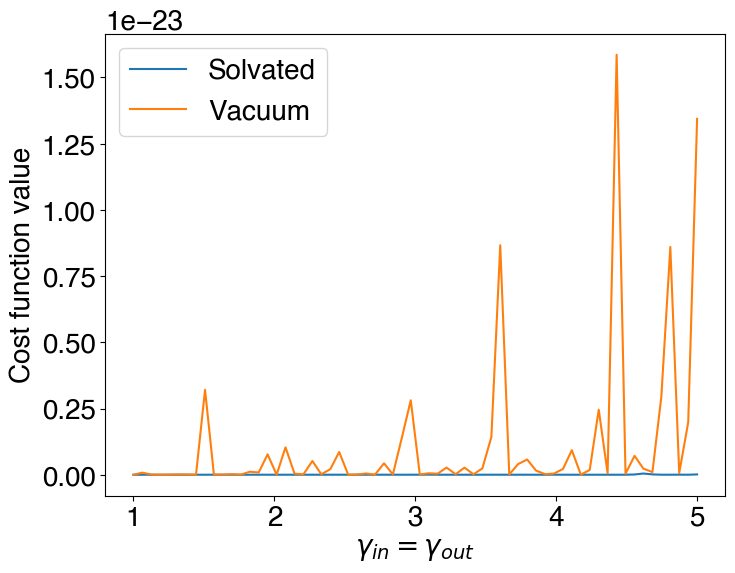

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(gamma_lst, solv_cost_val_lst, label='Solvated')
plt.plot(gamma_lst, vac_cost_val_lst, label='Vacuum')
plt.legend()
plt.xlabel(r'$\gamma_{in} = \gamma_{out}$')
plt.ylabel('Cost function value')
plt.show()

In [37]:
from qiskit.quantum_info import SparsePauliOp
def number_operator(L):
     z_terms = ["I"*(L-1-j) + "Z" + "I"*j for j in range(L)]
     op = SparsePauliOp(z_terms, -0.5*np.ones(L))
     op += SparsePauliOp(["I"*L], [0.5*L])
     return op.simplify().to_matrix()

In [38]:
I_in_solvated_lst = []
I_out_solvated_lst = []
I_in_vacuum_lst = []
I_out_vacuum_lst = []

N_expectation_values_solvated_lst = []
N_expectation_values_vacuum_lst = []

for i in range(len(solv_rho_lst)):
     rho_solvated_ss = solv_rho_lst[i]
     rho_vacuum_ss = vac_rho_lst[i]
     gamma_in = gamma_lst[i]
     gamma_out = gamma_lst[i]
     
     # Use L, not L-1
     N_op_solv = number_operator(vqa_solvated.L)
     N_op_vac = number_operator(vqa_vacuum.L)
     
     I_in_sol = gamma_in * (1 - np.trace(rho_solvated_ss @ N_op_solv))
     I_in_vac = gamma_in * (1 - np.trace(rho_vacuum_ss @ N_op_vac))
     I_out_sol = - gamma_out * np.trace(rho_solvated_ss @ N_op_solv)
     I_out_vac = - gamma_out * np.trace(rho_vacuum_ss @ N_op_vac)
     I_in_solvated_lst.append(np.real(I_in_sol))
     I_out_solvated_lst.append(np.real(I_out_sol))
     I_in_vacuum_lst.append(np.real(I_in_vac))
     I_out_vacuum_lst.append(np.real(I_out_vac))

     N_expect_solv = np.trace(rho_solvated_ss @ N_op_solv)
     N_expect_vac = np.trace(rho_vacuum_ss @ N_op_vac)
     N_expectation_values_solvated_lst.append(np.real(N_expect_solv))
     N_expectation_values_vacuum_lst.append(np.real(N_expect_vac))    

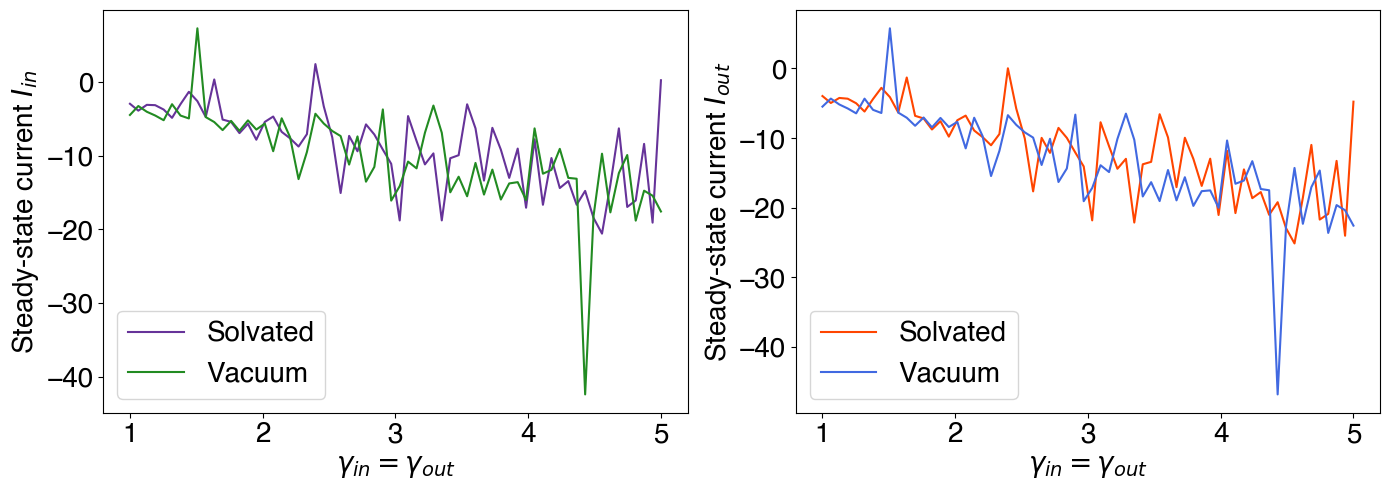

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(gamma_lst, I_in_solvated_lst, label='Solvated', color = "rebeccapurple")
ax1.plot(gamma_lst, I_in_vacuum_lst, label='Vacuum', color = "forestgreen")
ax1.set_xlabel(r'$\gamma_{in} = \gamma_{out}$')
ax1.set_ylabel(r'Steady-state current $I_{in}$')
ax1.legend()

ax2.plot(gamma_lst, I_out_solvated_lst, label='Solvated', color = "orangered")
ax2.plot(gamma_lst, I_out_vacuum_lst, label='Vacuum', color = "royalblue")
ax2.set_xlabel(r'$\gamma_{in} = \gamma_{out}$')
ax2.set_ylabel(r'Steady-state current $I_{out}$')
ax2.legend()

plt.tight_layout()
plt.show()

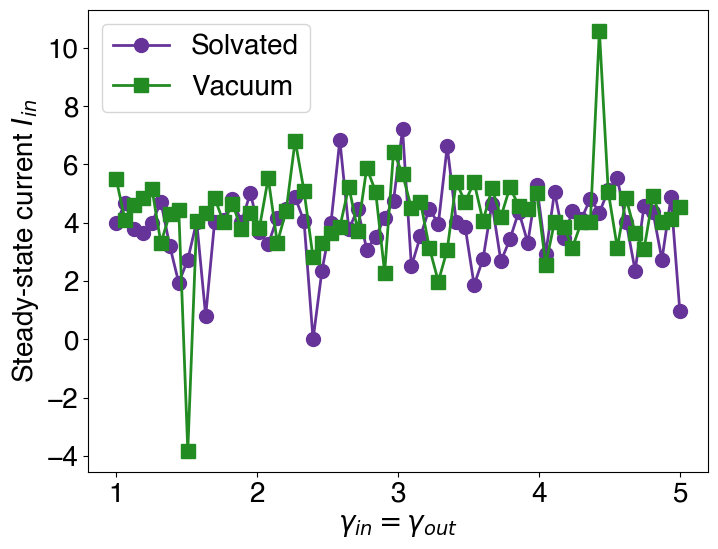

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(gamma_lst, N_expectation_values_solvated_lst, label='Solvated', marker='o', linewidth=2, color = "rebeccapurple", ms = 10)
ax.plot(gamma_lst, N_expectation_values_vacuum_lst, label='Vacuum', marker='s', linewidth=2, color = "forestgreen", ms = 10)
plt.legend()
plt.xlabel(r'$\gamma_{in} = \gamma_{out}$')
plt.ylabel(r'Steady-state current $I_{in}$')
plt.show()